In [2]:
from diffusers import AutoencoderKL, AutoPipelineForInpainting
from diffusers.utils import load_image
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as nnf
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation

In [4]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix",
                                    torch_dtype=torch.float16)
pipeline = AutoPipelineForInpainting.from_pretrained("diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
                                                     vae=vae, torch_dtype=torch.float16, variant="fp16",
                                                     use_safetensors=True).to("cuda")
pipeline.load_ip_adapter("h94/IP-Adapter",
                         subfolder="sdxl_models",
                         weight_name="ip-adapter_sdxl.bin",
                         low_cpu_mem_usage=True)

ip-adapter_sdxl.bin:   0%|          | 0.00/703M [00:00<?, ?B/s]

(…)dxl_models%2Fimage_encoder%2Fconfig.json:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.69G [00:00<?, ?B/s]

In [16]:
face = "/content/girl.jpg"
face_swap = "/content/girl2.png"
#face_swap = "/content/man photo.jpeg"

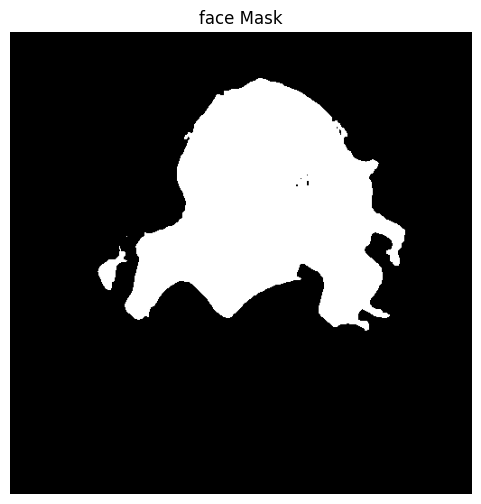

In [17]:
face = Image.open(face).convert("RGB").resize((512, 512))
face_swap = Image.open(face_swap).convert("RGB").resize((512, 512))

processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

inputs = processor(images=face, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nnf.interpolate(
    logits,
    size=face.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0].numpy()

face_label = 2
face_swap_label = 11

face_mask = (pred_seg == face_label).astype("uint8") * 255
face_swap_mask = (pred_seg == face_swap_label).astype("uint8") * 255

combined_mask = np.maximum(face_mask, face_swap_mask)

combined_mask_image = Image.fromarray(combined_mask).convert("L")

plt.figure(figsize=(6, 6))
plt.imshow(combined_mask_image, cmap='gray')
plt.title("face Mask")
plt.axis('off')
plt.show()


In [18]:
prompt = """A highly detailed and realistic human face with natural skin texture, well-lit features, and expressive eyes.
          The face seamlessly blends with the surrounding area, maintaining accurate lighting, color tones, and facial proportions.
          The expression remains natural, and the swapped face perfectly matches the head position and overall image aesthetics."""

negative_prompt = """Blurry details, distorted facial features, mismatched skin tones, unnatural lighting, asymmetrical face,
                    deformed eyes, excessive blur, cartoonish rendering, extra facial parts, unnatural expressions,
                     discolored skin patches, artifacts, and unrealistic blending."""

  0%|          | 0/14 [00:00<?, ?it/s]

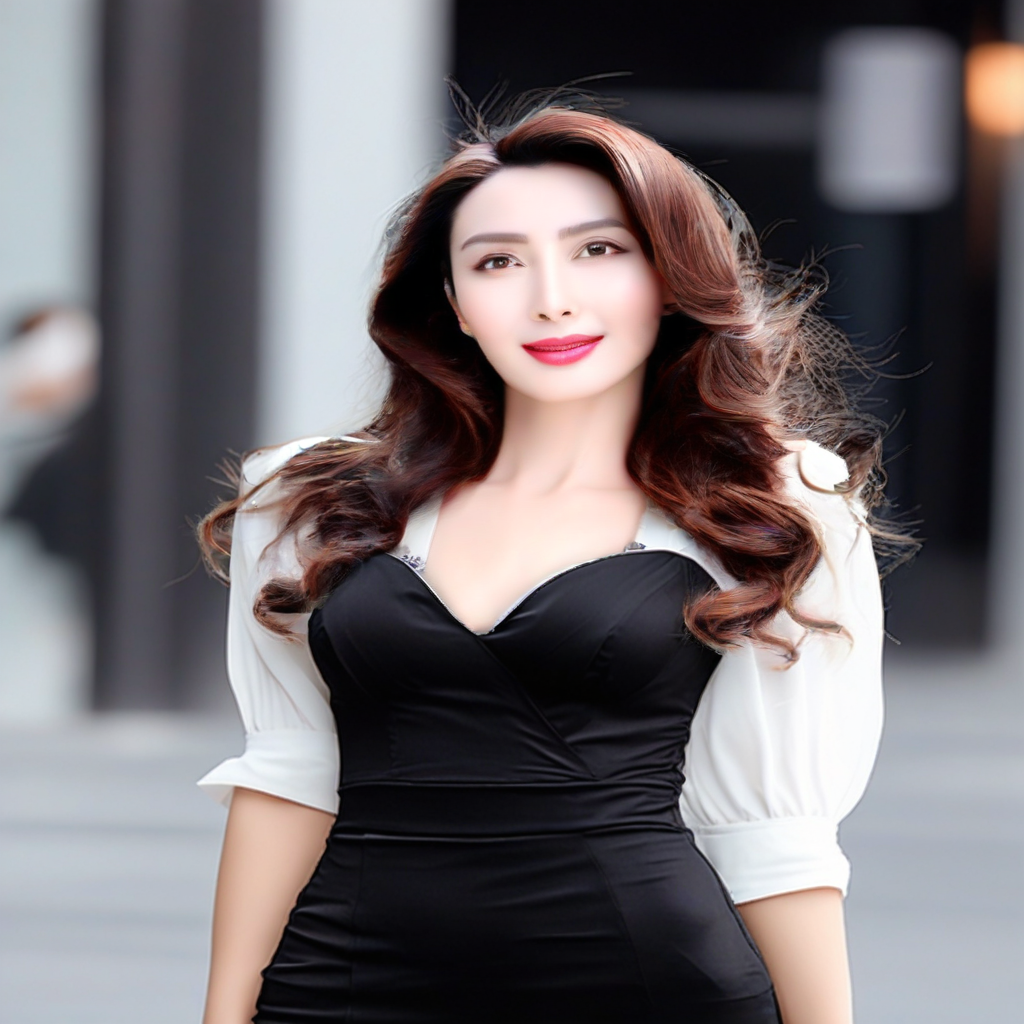

In [19]:
pipeline.set_ip_adapter_scale(1.0)
images = pipeline(
    prompt= prompt,
    negative_prompt=negative_prompt,
    image=face,
    mask_image=combined_mask_image,
    ip_adapter_image=face_swap,
    strength=0.99,
    guidance_scale=7.5,
    num_inference_steps=15,
).images
images[0]